## Correlation

Correlation Feature Selection evaluates subsets of features on the basis of the following hypothesis: "Good feature subsets contain features highly correlated with the target, yet uncorrelated to each other".

**References**:

M. Hall 1999, [Correlation-based Feature Selection for Machine Learning](http://www.cs.waikato.ac.nz/~mhall/thesis.pdf)

Senliol, Baris, et al. "Fast Correlation Based Filter (FCBF) with a different search strategy." Computer and Information Sciences.


I will demonstrate how to select features based on correlation using 2 procedures:

The first one is a brute force function that finds correlated features without any further insight. 

The second procedure finds groups of correlated features, which we can then explore to decide which one we keep and which ones we discard.

Often, more than 2 features are correlated with each other. We can find groups of 3, 4 or more features that are correlated. By identifying these groups, with procedure 2, we can then select from each group, which feature we want to keep, and which ones we want to remove.

**Note**

The most used method to determine correlation is the Pearson's correlation method, which is the one that I will carry out in this notebook.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

In [2]:
# load dataset

data = pd.read_csv('../dataset_2.csv', nrows=50000)
data.shape

(50000, 109)

In [3]:
data.head()

,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,...,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109
0,4.532710,3.280834,17.982476,4.404259,2.349910,0.603264,2.784655,0.323146,12.009691,0.139346,...,2.079066,6.748819,2.941445,18.360496,17.726613,7.774031,1.473441,1.973832,0.976806,2.541417
1,5.821374,12.098722,13.309151,4.125599,1.045386,1.832035,1.833494,0.709090,8.652883,0.102757,...,2.479789,7.795290,3.557890,17.383378,15.193423,8.263673,1.878108,0.567939,1.018818,1.416433
2,1.938776,7.952752,0.972671,3.459267,1.935782,0.621463,2.338139,0.344948,9.937850,11.691283,...,1.861487,6.130886,3.401064,15.850471,14.620599,6.849776,1.098210,1.959183,1.575493,1.857893
3,6.020690,9.900544,17.869637,4.366715,1.973693,2.026012,2.853025,0.674847,11.816859,0.011151,...,1.340944,7.240058,2.417235,15.194609,13.553772,7.229971,0.835158,2.234482,0.946170,2.700606
4,3.909506,10.576516,0.934191,3.419572,1.871438,3.340811,1.868282,0.439865,13.585620,1.153366,...,2.738095,6.565509,4.341414,15.893832,11.929787,6.954033,1.853364,0.511027,2.599562,0.811364


In practice, feature selection should be done after data pre-processing, so ideally, all the categorical variables are encoded into numbers, and then you can asses whether they are correlated with other features.

This dataset, for simplicity, contains only numerical variables.

**Important**

In all feature selection procedures, it is good practice to select the features by examining only the training set. And this is to avoid overfit.

In [4]:
# separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['target'], axis=1),
    data['target'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((35000, 108), (15000, 108))

## Correlation heatmap

<Axes: >

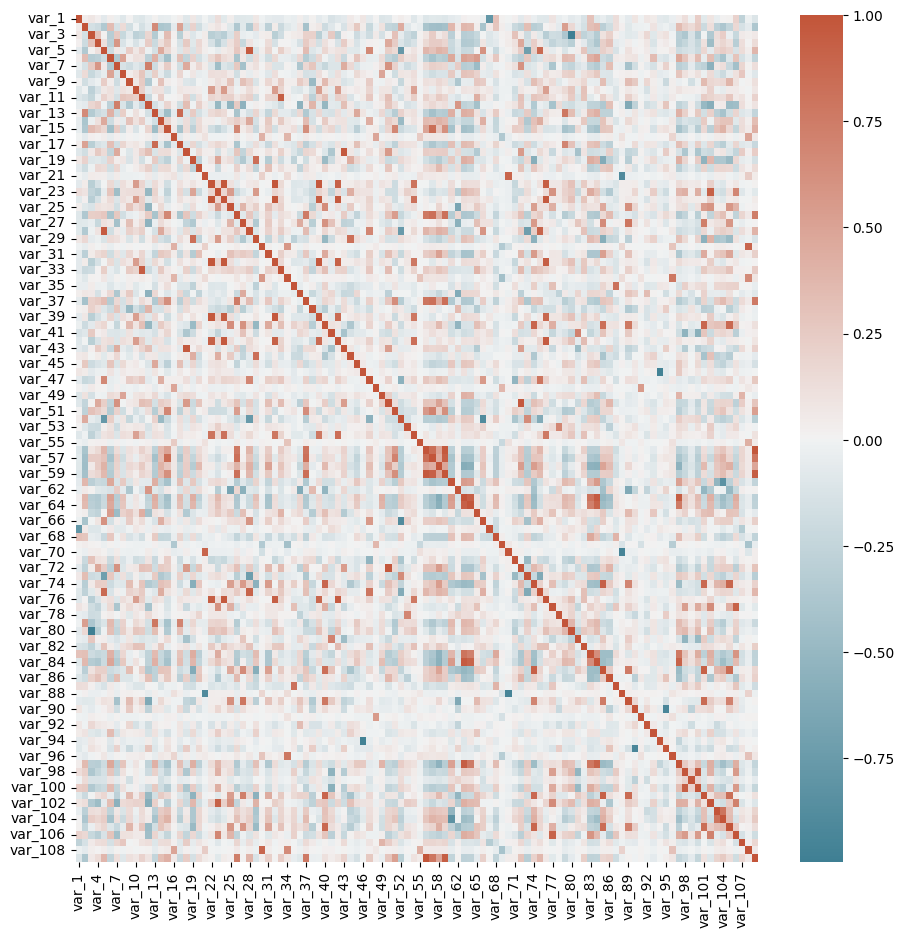

In [5]:
# visualise correlated features:

# I will build a correlation matrix, which examines the 
# correlation of all features (that is, for all possible feature combinations)
# and then visualise the correlation matrix using a heatmap

# the default correlation method of pandas.corr is pearson
# I include it anyways for the demo
corrmat = X_train.corr(method='pearson')

# we can make a heatmap with the package seaborn
# and customise the colours of searborn's heatmap
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# some more parameters for the figure
fig, ax = plt.subplots()
fig.set_size_inches(11,11)

# and now plot the correlation matrix
sns.heatmap(corrmat, cmap=cmap)

In the plot above, the dark orange squares correspond to highly correlated features (>0.8). Darker blue squares corresponds to negatively correlated features (<-0.8).

The diagonal represents the correlation of a feature with itself, therefore the value is 1.

We can see that there are a few features that are highly correlated.

## Correlation scatterplots

In [6]:
# Looking at the heatmap, we see that var25 is highly correlated 
# with others in the dataset

# with this code we can get the other variable names
# and also print the correlation coefficient between var25 and 
# these variables:

c = 0

# iterate over each correlation value for var_5:
for i in corrmat.loc['var_5']:
    
    # if highly correlated
    if i>0.8:
        
        # print the variable name and the correlation coefficient
        print(corrmat.columns[c], i)
        
    c = c +1

var_5 1.0
var_28 0.9536721652384935
var_75 0.8616179292025201


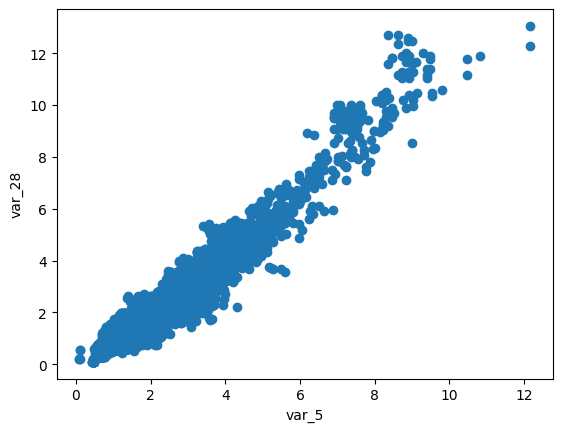

In [7]:
# now, let's plot the variables

plt.scatter(X_train['var_5'], X_train['var_28'])
plt.ylabel('var_28')
plt.xlabel('var_5')
plt.show()

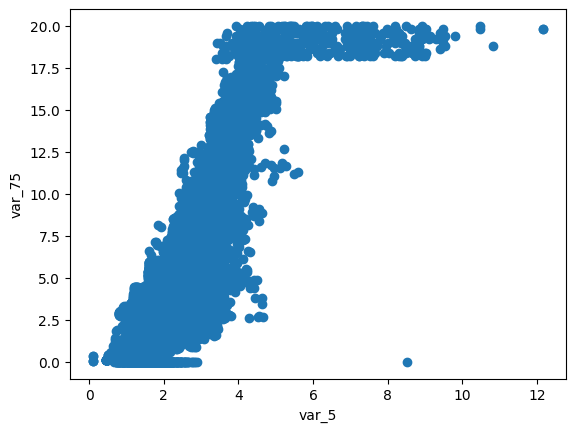

In [8]:
# now, let's plot the variables

plt.scatter(X_train['var_5'], X_train['var_75'])
plt.ylabel('var_75')
plt.xlabel('var_5')
plt.show()

We see that the correlation of the second pair of variables is not quite linear.

Next, let's identify a couple of negatively correlated variables:

In [9]:
c = 0
for i in corrmat.loc['var_88']:
    
    # if highly and negatively correlated
    if i<-0.8:
        
        # print the variable name and the correlation coefficient
        print(corrmat.columns[c], i)
        
    c = c +1

var_21 -0.8943929785046758
var_70 -0.9489465365954278


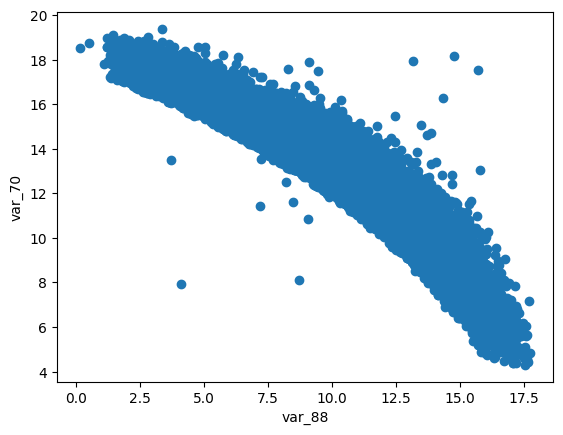

In [10]:
# now, let's plot the variables

plt.scatter(X_train['var_88'], X_train['var_70'])
plt.ylabel('var_70')
plt.xlabel('var_88')
plt.show()

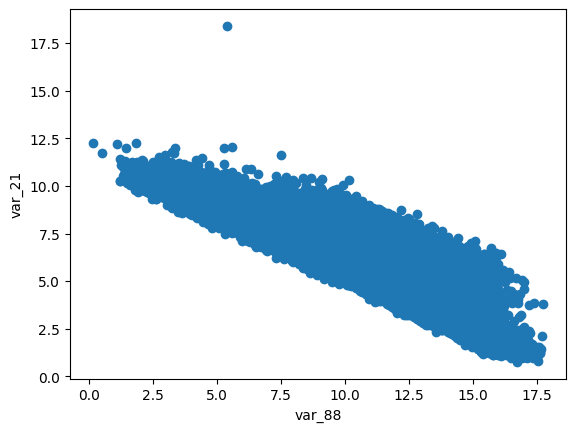

In [11]:
plt.scatter(X_train['var_88'], X_train['var_21'])
plt.ylabel('var_21')
plt.xlabel('var_88')
plt.show()

The higher the value of 1 variable, the lower the value of the other variable.

Now let's proceed with feature selection

## Remove correlated

### Brute force approach

In [12]:
# with the following function we can select highly correlated features
# it will remove the first feature that is correlated with anything else
# without any further insight.

def correlation(dataset, threshold):
    
    # create a set where I will store the names of correlated columns
    col_corr = set()
    
    # create the correlation matrix
    corr_matrix = dataset.corr()
    
    # for each feature in the dataset (columns of the correlation matrix)
    for i in range(len(corr_matrix.columns)):
        
        # check with other features
        for j in range(i):
            # if the correlation is higher than a certain threshold
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                
                # print correlation, and variables examined
                # keep in mind that the columns and rows of the dataframe are identical
                # so we can identify the features being examned by looking for i,j
                # in the column names
                print(abs(corr_matrix.iloc[i, j]), corr_matrix.columns[i], corr_matrix.columns[j])
                
                # get the name of the correlated feature
                colname = corr_matrix.columns[j]
                
                # and add it to our correlated set
                col_corr.add(colname)
                
    return col_corr

**Note**, if the code in cell 50 is hard to understand, either run the code line by line (you would have to manually enter some of the values of i), or add print statements within the loop to print the intermediate outputs.

In [13]:
corr_features = correlation(X_train, 0.8)
len(set(corr_features))

0.8632980418993791 var_17 var_13
0.9813409653986921 var_24 var_22
0.9536721652384935 var_28 var_5
0.8341792843814466 var_29 var_19
0.990430734999363 var_32 var_22
0.9804113632495293 var_32 var_24
0.9443605986205844 var_33 var_11
0.9744609333741678 var_39 var_22
0.9431153866790611 var_39 var_24
0.9748779191363224 var_39 var_32
0.91910579117498 var_42 var_22
0.9672922649953389 var_42 var_24
0.9199183443060952 var_42 var_32
0.8567453370818933 var_42 var_39
0.9654741987814475 var_43 var_18
0.8358214281472581 var_44 var_29
0.8150241475398633 var_54 var_24
0.8287090109274785 var_54 var_42
0.837404481636077 var_57 var_15
0.8318090759398273 var_57 var_26
0.8207993837973238 var_57 var_37
0.8440857367712562 var_57 var_56
0.8131947525226287 var_59 var_26
0.8306144274586774 var_59 var_37
0.9757443944210573 var_59 var_56
0.9223172758595293 var_59 var_57
0.9244600573582408 var_64 var_63
0.8925221926487203 var_66 var_52
0.895397163737887 var_70 var_21
0.9702627369945973 var_72 var_50
0.88311916559035

40

We can see that 40 features are highly correlated with other features in the training set. 

Very likely, by removing these correlated features, the performance of your machine learning models will drop very little, if at all. We can go ahead and drop the features like we have done in previous lectures.



In [14]:
corr_features

{'var_101',
 'var_103',
 'var_11',
 'var_13',
 'var_15',
 'var_18',
 'var_19',
 'var_21',
 'var_22',
 'var_23',
 'var_24',
 'var_26',
 'var_28',
 'var_29',
 'var_3',
 'var_30',
 'var_32',
 'var_35',
 'var_37',
 'var_39',
 'var_40',
 'var_42',
 'var_46',
 'var_5',
 'var_50',
 'var_52',
 'var_56',
 'var_57',
 'var_59',
 'var_60',
 'var_63',
 'var_64',
 'var_70',
 'var_74',
 'var_77',
 'var_84',
 'var_85',
 'var_89',
 'var_90',
 'var_98'}

In [15]:
X_train.drop(labels=corr_features, axis=1, inplace=True)
X_test.drop(labels=corr_features, axis=1, inplace=True)

X_train.shape, X_test.shape

((35000, 68), (15000, 68))

By removing correlated columns we reduced the feature space from 108 numerical columns to 68.

### Second approach

The second approach looks to identify groups of highly correlated features. And then, we can make further investigation within these groups to decide which feature we keep and which one we remove.

In [24]:
# separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['target'], axis=1),
    data['target'],
    test_size=0.3,
    random_state=0)

In [26]:
# build a dataframe with the correlation between features
# remember that the absolute value of the correlation
# coefficient is important and not the sign

corrmat = X_train.corr()
corrmat = corrmat.abs().unstack() # absolute value of corr coef
corrmat = corrmat.sort_values(ascending=False)
corrmat = corrmat[corrmat >= 0.8]
corrmat = corrmat[corrmat < 1]
corrmat = pd.DataFrame(corrmat).reset_index()
corrmat.columns = ['feature1', 'feature2', 'corr']
corrmat.head(20)

,feature1,feature2,corr
0,var_80,var_3,0.994923
1,var_3,var_80,0.994923
2,var_32,var_22,0.990431
3,var_22,var_32,0.990431
4,var_56,var_109,0.987777
5,var_109,var_56,0.987777
6,var_24,var_22,0.981341
7,var_22,var_24,0.981341
8,var_32,var_24,0.980411
9,var_24,var_32,0.980411


**Note**, if the code above is not clear, run each command individually.

In [29]:
# find groups of correlated features

grouped_feature_ls = []
correlated_groups = []

for feature in corrmat.feature1.unique():
    
    if feature not in grouped_feature_ls:

        # find all features correlated to a single feature
        correlated_block = corrmat[corrmat.feature1 == feature]
        grouped_feature_ls = grouped_feature_ls + list(
            correlated_block.feature2.unique()) + [feature]
        
        # append the block of features to the list
        correlated_groups.append(correlated_block)

print('found {} correlated groups'.format(len(correlated_groups)))
print('out of {} total features'.format(X_train.shape[1]))
print(grouped_feature_ls)
print(correlated_groups)

found 27 correlated groups
out of 108 total features
['var_3', 'var_80', 'var_22', 'var_24', 'var_39', 'var_76', 'var_42', 'var_32', 'var_109', 'var_59', 'var_57', 'var_56', 'var_50', 'var_72', 'var_46', 'var_94', 'var_18', 'var_43', 'var_84', 'var_97', 'var_64', 'var_63', 'var_5', 'var_75', 'var_28', 'var_70', 'var_21', 'var_88', 'var_33', 'var_11', 'var_100', 'var_98', 'var_74', 'var_101', 'var_105', 'var_40', 'var_85', 'var_90', 'var_95', 'var_23', 'var_102', 'var_77', 'var_106', 'var_66', 'var_52', 'var_108', 'var_30', 'var_13', 'var_17', 'var_101', 'var_89', 'var_57', 'var_15', 'var_44', 'var_19', 'var_29', 'var_57', 'var_59', 'var_26', 'var_59', 'var_57', 'var_37', 'var_104', 'var_60', 'var_42', 'var_24', 'var_54', 'var_87', 'var_35', 'var_104', 'var_103']
[  feature1 feature2      corr
0   var_80    var_3  0.994923,    feature1 feature2      corr
2    var_32   var_22  0.990431
8    var_32   var_24  0.980411
13   var_32   var_39  0.974878
47   var_32   var_76  0.931718
56   var_3

In [19]:
# now we can print out each group. We see that some groups contain
# only 2 correlated features, some other groups present several features 
# that are correlated among themselves.

for group in correlated_groups:
    print(group)
    print()

  feature1 feature2      corr
0   var_80    var_3  0.994923

   feature1 feature2      corr
2    var_32   var_22  0.990431
8    var_32   var_24  0.980411
13   var_32   var_39  0.974878
47   var_32   var_76  0.931718
56   var_32   var_42  0.919918

    feature1 feature2      corr
4     var_56  var_109  0.987777
11    var_56   var_59  0.975744
103   var_56   var_57  0.844086

   feature1 feature2      corr
16   var_72   var_50  0.970263

   feature1 feature2      corr
18   var_94   var_46  0.967895

   feature1 feature2      corr
22   var_43   var_18  0.965474

   feature1 feature2      corr
26   var_63   var_84  0.959138
40   var_63   var_97  0.940184
53   var_63   var_64  0.924460

   feature1 feature2      corr
30   var_28    var_5  0.953672
67   var_28   var_75  0.904413

   feature1 feature2      corr
32   var_88   var_70  0.948947
75   var_88   var_21  0.894393

   feature1 feature2      corr
36   var_11   var_33  0.944361

   feature1 feature2      corr
42   var_98  var_100  0.938

In [20]:
# we can now investigate further features within one group.
# let's for example select group 1

group = correlated_groups[1]
group

,feature1,feature2,corr
2,var_32,var_22,0.990431
8,var_32,var_24,0.980411
13,var_32,var_39,0.974878
47,var_32,var_76,0.931718
56,var_32,var_42,0.919918


**In this group, several features are highly correlated. Which one should we keep and which ones should we remove?**

One criteria to select which features to use from this group, would be to use those with **less missing data**. 

Our dataset contains no missing values, so this is not an option. But keep this in mind when you work with your own datasets.

Alternatively, we could build a **machine learning algorithm using all the features from the above list, and select the more predictive one**.

In [31]:
from sklearn.ensemble import RandomForestClassifier

# add all features of the group to a list
features = list(group['feature2'].unique())+['var_32']
print(features)

# train a random forest 
rf = RandomForestClassifier(n_estimators=200, random_state=39, max_depth=4)
rf.fit(X_train[features].fillna(0), y_train)

['var_22', 'var_24', 'var_39', 'var_76', 'var_42', 'var_32']


RandomForestClassifier(max_depth=4, n_estimators=200, random_state=39)

In [32]:
# get the feature importance attributed by the 
# random forest model (more on this in coming lectures)

importance = pd.concat(
    [pd.Series(features),
     pd.Series(rf.feature_importances_)], axis=1)

importance.columns = ['feature', 'importance']

# sort features by importance, most important first
importance.sort_values(by='importance', ascending=False)

,feature,importance
2,var_39,0.194210
3,var_76,0.187360
0,var_22,0.167467
1,var_24,0.167054
4,var_42,0.147102
5,var_32,0.136807


In this case, feature var_39 shows the highest importance according to random forests. Then, I would select var_39, and remove all the remaining features from this group from the dataset.

**Note**

None of the 2 procedures for removing correlated features are perfect, and some correlated features may escape the loops of code. So it might be worthwhile checking that after removing the correlated features, there are no correlated features left in the dataset. If there are, repeat the procedure to remove the remaining ones.

That is all for this lecture, I hope you enjoyed it and see you in the next one!

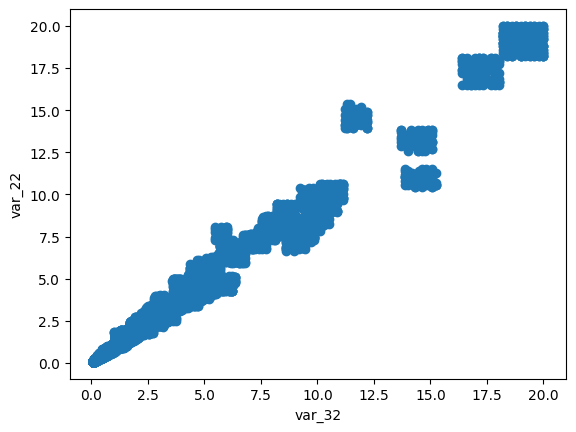

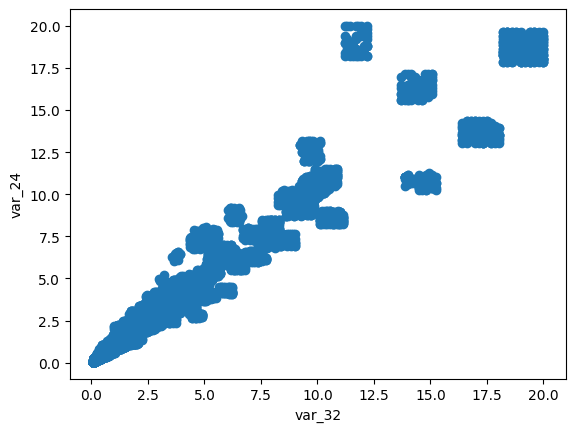

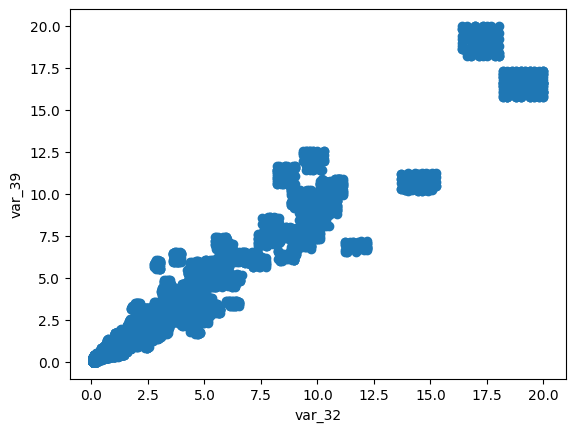

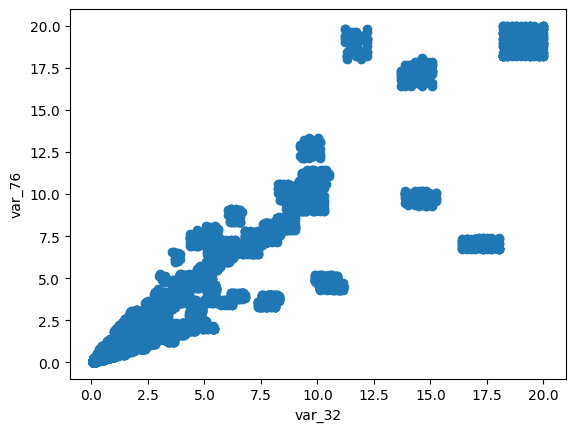

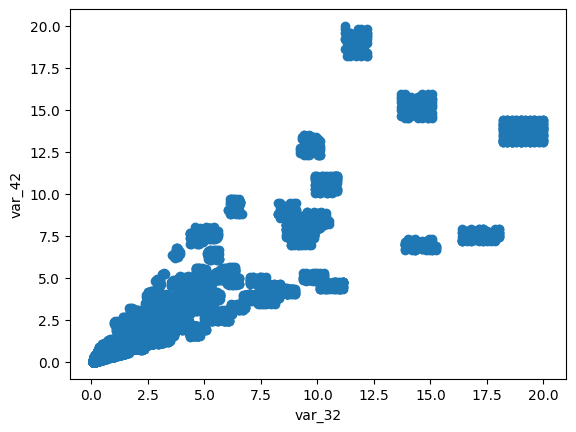

In [34]:
# BONUS:
# let's plot the correlation of the features in the correlated group from the
# previous cell

for feature in group['feature2']:
    plt.scatter(X_train['var_32'], X_train[feature])
    plt.xlabel('var_32')
    plt.ylabel(feature)
    plt.show()